In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from datetime import date

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/CSC8498_Dissertation/'

raw_data_df = pd.read_csv(path + 'Raw_Data/2018-2022.csv')

Mounted at /content/drive


In [3]:
raw_data_df.head(5)

,Unnamed: 0,date_time,intensity_forecast,intensity_actual
0,0,2018-01-01T0015,154,157.0
1,1,2018-01-01T0045,159,164.0
2,2,2018-01-01T0115,169,171.0
3,3,2018-01-01T0145,170,172.0
4,4,2018-01-01T0215,165,172.0


In [4]:
start_date_time = raw_data_df['date_time'].iloc[0]
end_date_time = raw_data_df['date_time'].iloc[len(raw_data_df)-1]

date_times = pd.date_range(start=start_date_time, end=end_date_time, freq='30T')

date_time_df = pd.DataFrame(date_times, columns=['date_time'])
date_time_df.head(5)

,date_time
0,2018-01-01 00:15:00
1,2018-01-01 00:45:00
2,2018-01-01 01:15:00
3,2018-01-01 01:45:00
4,2018-01-01 02:15:00


In [5]:
intensity_data_df = raw_data_df[['date_time', 'intensity_actual']]
intensity_data_df = intensity_data_df.assign(date_time=lambda df: pd.to_datetime(df['date_time']))
intensity_data_df.head(5)

,date_time,intensity_actual
0,2018-01-01 00:15:00,157.0
1,2018-01-01 00:45:00,164.0
2,2018-01-01 01:15:00,171.0
3,2018-01-01 01:45:00,172.0
4,2018-01-01 02:15:00,172.0


In [6]:
df = pd.merge(date_time_df, intensity_data_df, how='outer', on=['date_time'])
df = df.set_index('date_time')
df.head(5)

,intensity_actual
date_time,
2018-01-01 00:15:00,157.0
2018-01-01 00:45:00,164.0
2018-01-01 01:15:00,171.0
2018-01-01 01:45:00,172.0
2018-01-01 02:15:00,172.0


In [7]:
print('Null values found: %d' % df.isnull().sum())

Null values found: 3541


In [8]:
# Correct null values in data
df['intensity_actual'] = df['intensity_actual'].interpolate(method='linear')

In [9]:
print('Null values found: %d' % df.isnull().sum())

Null values found: 0


<Axes: xlabel='date_time'>

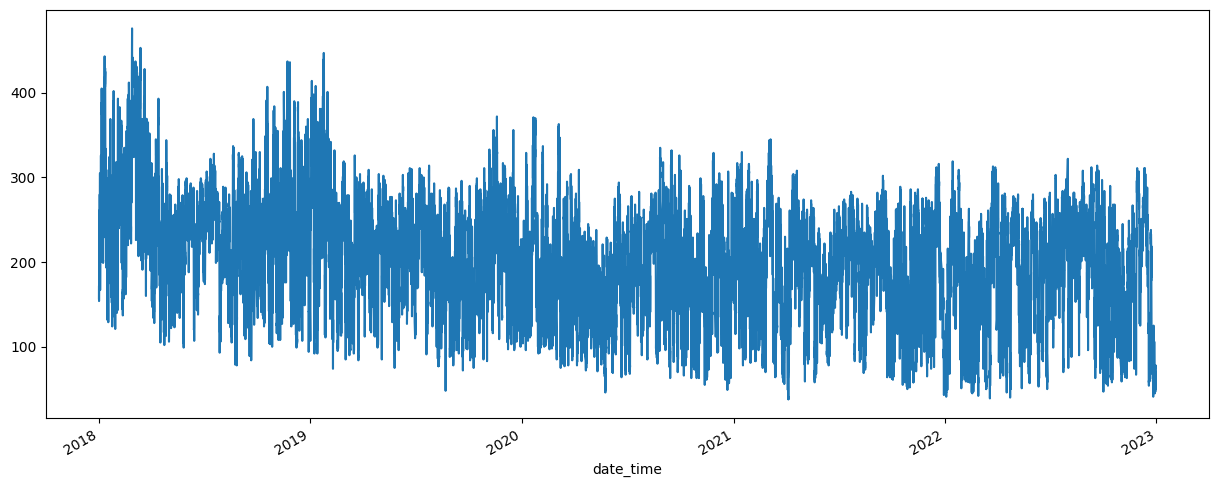

In [10]:
df['intensity_actual'].plot(figsize = (15,6))

<Axes: >

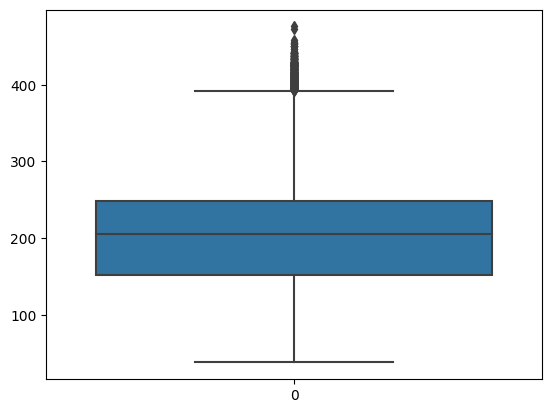

In [11]:
sns.boxplot(df['intensity_actual'])

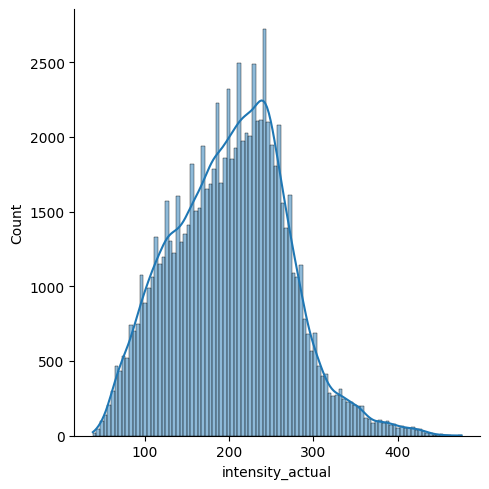

In [12]:
sns.displot(df['intensity_actual'], kde=True)

Best Lambda Value: 0.7866


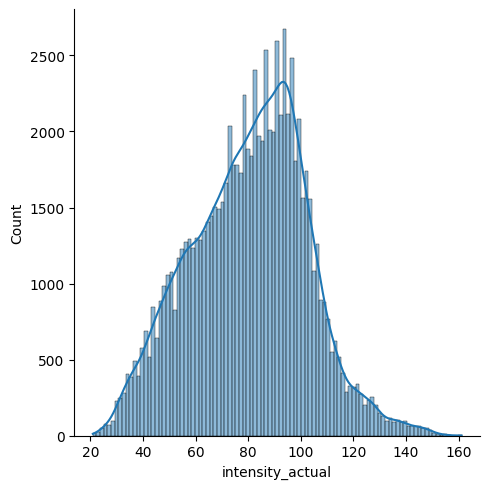

In [13]:
from scipy.stats import boxcox

df['intensity_actual'], best_lambda = boxcox(df['intensity_actual'])
print('Best Lambda Value: %.4f' % best_lambda)

sns.displot(df['intensity_actual'], kde=True)

In [14]:
# df with column for each hour
hours_df = pd.DataFrame()

hours_df['date'] = df.index.date
hours_df['hours'] = df.index.hour
hours_df['intensity'] = df.values

hours_df = hours_df.set_index(['date', 'hours'], append=True).unstack()
# Down sample from half hourly --> hourly
hours_df = hours_df.groupby(['date']).mean()
hours_df.head(5)

intensity                                                  \
hours               0           1           2           3           4    
date                                                                     
2018-01-01   67.761825   71.459789   71.292786   70.622664   66.066655   
2018-01-02   74.111532   79.025948   83.857180   89.876608   94.086252   
2018-01-03   75.103626   70.456717   70.791777   73.120199   74.277508   
2018-01-04   87.988623   88.304034   92.531342   97.934868  101.449966   
2018-01-05  101.751665  105.077876  106.579471  107.776432  110.012020   

                                                                        ...  \
hours               5           6           7           8           9   ...   
date                                                                    ...   
2018-01-01   67.595128   73.783718   73.619528   76.577662   81.609772  ...   
2018-01-02   94.860529   96.402246  101.296558  104.475582  103.570274  ...   
2018-01-03   74.610412   81.440089   88.304034   90.502995   90.973218  ...   
2018-01-04  104.173969  108.517189  115.181265  117.961661  118.399150  ...   
2018-01-05  112.086400  116.644691  123.757454  132.598248  136.825346  ...   

                                                                        \
hours               14          15          16          17          18   
date                                                                     
2018-01-01   98.550490   99.317598   99.011849   97.172893   96.095753   
2018-01-02   99.775277  102.204968  110.160423  111.345010  112.973965   
2018-01-03   91.128808   97.016576  100.232460  101.297291  102.359679   
2018-01-04  104.173033  107.328060  113.263217  117.815606  118.253482   
2018-01-05  134.577266  137.524478  141.012720  139.481506  138.224913   

                                                                        
hours               19          20          21          22          23  
date                                                                    
2018-01-01   91.901281   84.497139   80.806164   74.601078   71.958937  
2018-01-02  107.472421   96.394342   88.773191   80.151423   76.418123  
2018-01-03   99.315584   94.547319   88.617648   82.574247   82.575914  
2018-01-04  115.620612  108.961761  100.383782   97.172373   96.094165  
2018-01-05  135.841318  130.050863  124.327721  112.672921  105.076028  

[5 rows x 24 columns]

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Scale intensity to 0-1
hours_np = hours_df['intensity'].to_numpy()

scaler = MinMaxScaler()
scaler.fit(hours_np)
norm_data = scaler.transform(hours_np)

norm_df = pd.DataFrame(norm_data, index=hours_df.index, columns=hours_df.columns)

In [16]:
norm_df.head(10)

intensity                                                    \
hours             0         1         2         3         4         5    
date                                                                     
2018-01-01  0.337572  0.350064  0.360107  0.361165  0.327580  0.319513   
2018-01-02  0.386934  0.408167  0.456925  0.508579  0.540707  0.518841   
2018-01-03  0.394646  0.342362  0.356246  0.380287  0.390035  0.370799   
2018-01-04  0.494813  0.479416  0.523766  0.570275  0.596718  0.586928   
2018-01-05  0.601805  0.608226  0.632017  0.645625  0.661844  0.644773   
2018-01-06  0.602998  0.582694  0.577224  0.549049  0.515826  0.458197   
2018-01-07  0.493584  0.496302  0.515372  0.516966  0.507491  0.481259   
2018-01-08  0.478815  0.456308  0.442118  0.444092  0.438486  0.423178   
2018-01-09  0.532547  0.523823  0.533358  0.552652  0.559506  0.528997   
2018-01-10  0.608887  0.600122  0.634327  0.647913  0.666359  0.658792   

                                                    ...                      \
hours             6         7         8         9   ...        14        15   
date                                                ...                       
2018-01-01  0.377195  0.386962  0.403664  0.452714  ...  0.596429  0.612248   
2018-01-02  0.554477  0.605270  0.625783  0.632476  ...  0.606041  0.635547   
2018-01-03  0.437205  0.502789  0.514535  0.529361  ...  0.538185  0.593680   
2018-01-04  0.649434  0.714788  0.733157  0.753861  ...  0.640554  0.676887   
2018-01-05  0.713136  0.782434  0.849691  0.904693  ...  0.879163  0.920550   
2018-01-06  0.509469  0.491576  0.513254  0.562449  ...  0.558964  0.610903   
2018-01-07  0.520485  0.565462  0.547983  0.583880  ...  0.632227  0.723582   
2018-01-08  0.499584  0.598027  0.635363  0.652197  ...  0.726948  0.754433   
2018-01-09  0.612847  0.741304  0.757462  0.780009  ...  0.802155  0.825697   
2018-01-10  0.748456  0.853278  0.901159  0.937835  ...  0.927477  0.992225   

                                                                        \
hours             16        17        18        19        20        21   
date                                                                     
2018-01-01  0.580742  0.545480  0.554783  0.516508  0.465219  0.434327   
2018-01-02  0.670066  0.657638  0.689804  0.642016  0.559632  0.498845   
2018-01-03  0.590522  0.578120  0.604893  0.576270  0.544974  0.497585   
2018-01-04  0.694926  0.708847  0.732039  0.707692  0.659364  0.592870   
2018-01-05  0.917259  0.880311  0.891806  0.870676  0.826722  0.786772   
2018-01-06  0.653340  0.652966  0.662542  0.646846  0.600955  0.575533   
2018-01-07  0.783598  0.775201  0.781827  0.749968  0.688844  0.592699   
2018-01-08  0.747733  0.714619  0.732038  0.714777  0.677075  0.595292   
2018-01-09  0.804312  0.784253  0.835506  0.794111  0.736521  0.674437   
2018-01-10  0.971500  0.947091  0.987989  1.000000  0.953243  0.890180   

                                
hours             22        23  
date                            
2018-01-01  0.383871  0.376051  
2018-01-02  0.428593  0.412614  
2018-01-03  0.448114  0.463103  
2018-01-04  0.565739  0.573944  
2018-01-05  0.690634  0.647589  
2018-01-06  0.524589  0.520393  
2018-01-07  0.504390  0.460498  
2018-01-08  0.539594  0.529386  
2018-01-09  0.611145  0.614117  
2018-01-10  0.805318  0.838355  

[10 rows x 24 columns]

In [17]:
# Produce features and labels from dataset
def feature_labels(arr, feature_len):
  features = []
  labels = []

  i = feature_len
  while i < len(arr):
    for j in range(len(arr[0])):
      features.append(arr[:, j][i-feature_len:i])
      labels.append(arr[:, j][i])
    i += 1
  
  return np.array(features), np.array(labels)

In [18]:
n_input = 20
n_features = 1

norm_np = norm_df.to_numpy()

features, labels = feature_labels(norm_np, n_input)

In [19]:
features.shape, labels.shape

((43320, 20), (43320,))

In [20]:
features = np.reshape(features, (1805, 20, 24))
features = np.swapaxes(features, -1, -1)
labels = np.reshape(labels, (1805, 24))

features.shape, labels.shape

((1805, 20, 24), (1805, 24))

In [21]:
train_x = features[:int(0.8 * len(features))]
train_y = labels[:int(0.8 * len(labels))]

test_x = features[int(0.8 * len(features)):]
test_y= labels[int(0.8 * len(labels)):]

In [22]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1444, 20, 24), (1444, 24), (361, 20, 24), (361, 24))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20, 100)           2500      
                                                                 
 dense_1 (Dense)             (None, 20, 24)            2424      
                                                                 
 dense_2 (Dense)             (None, 20, 24)            600       
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense_3 (Dense)             (None, 24)                11544     
                                                                 
Total params: 17,068
Trainable params: 14,568
Non-trainable params: 2,500
_________________________________________________________________


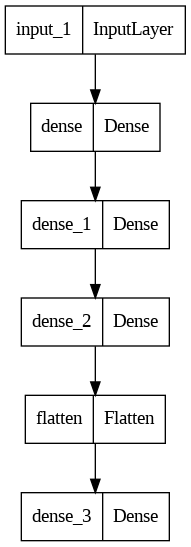

In [23]:
from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dropout, Dense, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model

model = Sequential()

# Input layer
model.add(InputLayer(input_shape=(20, 24)))
model.add(Dense(units=100, activation='relu', input_dim=24, trainable=False))


weights = model.layers[-1].get_weights()
weights[0] = np.random.random_sample((24, 100))
model.layers[-1].set_weights(weights)

model.add(Dense(units=24, activation='relu', trainable=True))
model.add(Dense(units=24, activation='relu', trainable=True))

model.add(Flatten())
model.add(Dense(units=24, trainable=True))

model.compile(loss='mae', optimizer=Adam(learning_rate=0.001))
model.summary()

plot_model(model)

In [24]:
model.fit(train_x, train_y)

46/46 [==============================] - 1s 3ms/step - loss: 0.3733


In [25]:
test_predictions = model.predict(test_x)

12/12 [==============================] - 0s 2ms/step


In [26]:
from scipy.special import inv_boxcox

test_y_denorm = scaler.inverse_transform(test_y.flatten().reshape(361, 24)).flatten()
test_y_denorm = inv_boxcox(test_y_denorm, best_lambda)

test_predictions_denorm = scaler.inverse_transform(test_predictions.flatten().reshape(361, 24)).flatten()
test_predictions_denorm = inv_boxcox(test_predictions_denorm, best_lambda)

mape = np.mean(np.abs((test_y_denorm - test_predictions_denorm) / test_y_denorm)) * 100
print('Mean Absolute Percentage Error: %.4f%%' % mape)

Mean Absolute Percentage Error: 46.0284%


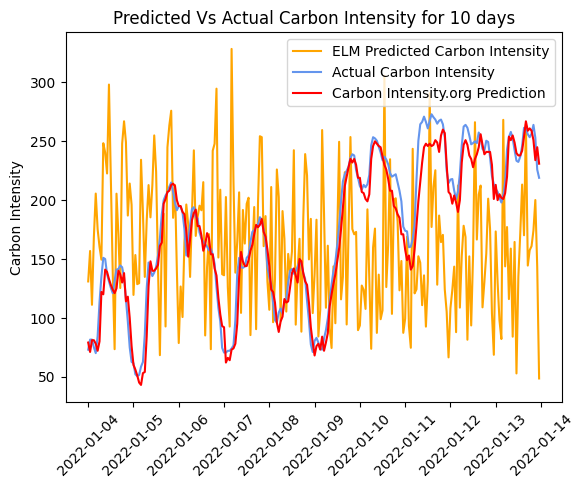

In [27]:
plt.plot(np.arange(np.datetime64('2022-01-04T00:00'), np.datetime64('2022-01-14T00:00'), np.timedelta64(1, 'h')), test_predictions_denorm[:240], color='orange', label='ELM Predicted Carbon Intensity')
plt.plot(np.arange(np.datetime64('2022-01-04T00:00'), np.datetime64('2022-01-14T00:00'), np.timedelta64(1, 'h')), test_y_denorm[:240], color='cornflowerblue', label='Actual Carbon Intensity')
plt.plot(np.arange(np.datetime64('2022-01-04T00:00'), np.datetime64('2022-01-14T00:00'), np.timedelta64(1, 'h')), raw_data_df['intensity_forecast'][67864:68344].iloc[::2], color='red', label='Carbon Intensity.org Prediction')
plt.title('Predicted Vs Actual Carbon Intensity for 10 days')
plt.ylabel('Carbon Intensity')
plt.xticks(rotation=45)
plt.legend()

In [28]:
pred_data = test_x[360]
pred_data = np.reshape(pred_data, (1, 20, 24))
preds = model.predict(pred_data, verbose=0).flatten()

In [29]:
plot_data = scaler.inverse_transform(preds.reshape(1, 24)).flatten()
plot_data = inv_boxcox(plot_data, best_lambda)

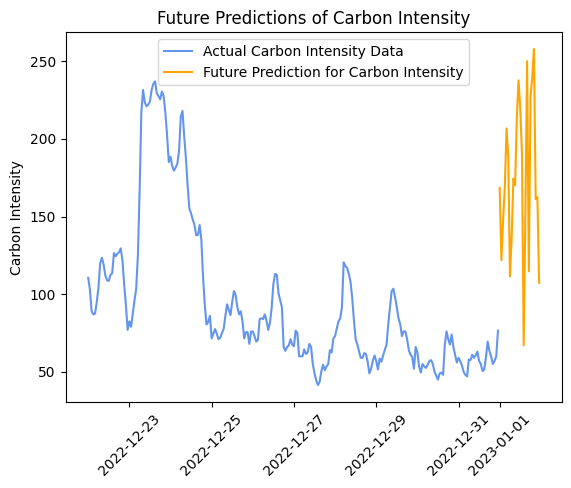

In [30]:
plt.plot(np.arange(np.datetime64('2022-12-22T00:00'), np.datetime64('2023-01-01T00:00'), np.timedelta64(1, 'h')), test_y_denorm[len(test_y_denorm)-240:], color='cornflowerblue', label='Actual Carbon Intensity Data')
plt.plot(np.arange(np.datetime64('2023-01-01T00:00'), np.datetime64('2023-01-02T00:00'), np.timedelta64(1, 'h')), plot_data, color='orange', label='Future Prediction for Carbon Intensity')
plt.title('Future Predictions of Carbon Intensity')
plt.ylabel('Carbon Intensity')
plt.xticks(rotation=45)
plt.legend()